# problem defination(The mckinsey way)

In [ ]:
store segmentation: Identify the store level segments
Outcomes: Redefine the store level fuctioning, learn from better performing store and apply the factors to non performing stores.

In [7]:
<img src="store image.png" alt="image of a store" height="42" width="42">

SyntaxError: invalid syntax (<ipython-input-7-bb0f5fd58798>, line 1)

# Creation of base dataset

In [8]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
import glob
import matplotlib.pyplot as plt

### a.	ML : Databases

### b.	NLP : Web Scraping

### c.	AI : Pre Trained Models ( Google, tesla, biadu, image net)

# Pre Processing

In [14]:
df=pd.read_csv(r"C:\Users\abhisv.CORP\3D Objects\train.csv")

D:\Python\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [15]:
base_dataset_backup=df

### a.	Memory Management

In [16]:
start_mem = df.memory_usage().sum() / 1024**2
print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

for col in df.columns:
    col_type = df[col].dtype

    if col_type != object:
        c_min = df[col].min()
        c_max = df[col].max()
        if str(col_type)[:3] == 'int':
            if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                df[col] = df[col].astype(np.int8)
            elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                df[col] = df[col].astype(np.int16)
            elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                df[col] = df[col].astype(np.int32)
            elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                df[col] = df[col].astype(np.int64)  
        else:
            if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                df[col] = df[col].astype(np.float16)
            elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                df[col] = df[col].astype(np.float32)
            else:
                df[col] = df[col].astype(np.float64)
    else:
        df[col] = df[col].astype('category')

end_mem = df.memory_usage().sum() / 1024**2
print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

Memory usage of dataframe is 69.85 MB
Memory usage after optimization is: 14.60 MB
Decreased by 79.1%


In [17]:
df.dtypes

Store               int16
DayOfWeek            int8
Date             category
Sales               int32
Customers           int16
Open                 int8
Promo                int8
StateHoliday     category
SchoolHoliday        int8
dtype: object

In [25]:
base_df=df.groupby('Store').sum()[['Customers','Sales']]

In [26]:
base_df.reset_index(inplace=True)

In [27]:
base_df.head()

,Store,Customers,Sales
0,1,440523.0,3716854
1,2,457855.0,3883858
2,3,584310.0,5408261
3,4,1036254.0,7556507
4,5,418588.0,3642818


In [28]:
base_df.shape

(1115, 3)

### b.Null value treatment

In [30]:
def null_values(base_dataset):
    print(base_dataset.isna().sum())
    ## null value percentage     
    null_value_table=(base_dataset.isna().sum()/base_dataset.shape[0])*100
    ## null value percentage beyond threshold drop , else treat the columns 
    
    retained_columns=null_value_table[null_value_table<int(input())].index
    # if any variable as null value greater than input(like 30% of the data) value than those variable are consider as drop
    drop_columns=null_value_table[null_value_table>int(input())].index
    base_dataset.drop(drop_columns,axis=1,inplace=True)
    len(base_dataset.isna().sum().index)
    cont=base_dataset.describe().columns
    cat=[i for i in base_dataset.columns if i not in base_dataset.describe().columns]
    for i in cat:
        base_dataset[i].fillna(base_dataset[i].value_counts().index[0],inplace=True)
    for i in cont:
        base_dataset[i].fillna(base_dataset[i].median(),inplace=True)
    print(base_dataset.isna().sum())
    return base_dataset,cat,cont

In [31]:
base_Df_nullvalues_treated,cat,cont=null_values(base_df)

Store        0
Customers    0
Sales        0
dtype: int64
30
30
Store        0
Customers    0
Sales        0
dtype: int64


In [32]:
base_df.columns

Index(['Store', 'Customers', 'Sales'], dtype='object')

### c.Outlier treatment

(array([       0.,  2500000.,  5000000.,  7500000., 10000000., 12500000.,
        15000000., 17500000., 20000000., 22500000.]),
 <a list of 10 Text xticklabel objects>)

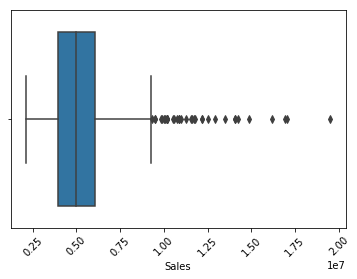

In [33]:
sns.boxplot(base_df['Sales'])
plt.xticks(rotation=45)

(array([      0.,  500000., 1000000., 1500000., 2000000., 2500000.,
        3000000., 3500000.]), <a list of 8 Text xticklabel objects>)

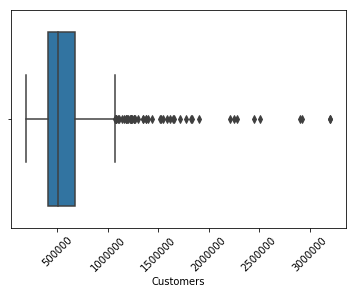

In [34]:
import seaborn as sns
sns.boxplot(base_df['Customers'])
plt.xticks(rotation=45)

In [41]:
def outliers_transform(base_dataset):
    for i in base_dataset.var().sort_values(ascending=False).index[1:10]:
        x=np.array(base_dataset[i])
        qr1=np.quantile(x,0.25)
        qr3=np.quantile(x,0.75)
        iqr=qr3-qr1
        utv=qr3+(1.5*(iqr))
        ltv=qr1-(1.5*(iqr))
        y=[]
        for p in x:
            if p <ltv or p>utv:
                y.append(np.median(x))
            else:
                y.append(p)
        base_dataset[i]=y

### d.	Label encoders

In [42]:
from sklearn.preprocessing import LabelEncoder
def label_encoders(data,cat):
    le=LabelEncoder()
    for i in cat:
        le.fit(data[i])
        x=le.transform(data[i])
        data[i]=x
    return data

### e.Min max scalar

In [43]:
from sklearn.preprocessing import MinMaxScaler
def MinMaxScaler(data):
    le=MinMaxScaler()
    le.fit(data)
    x=le.transform(data)
    dat1=pd.DataFrame(x)
    dat1.columns=data.columns
    data=data1
    return data

### f.	Standard scalar

In [45]:
from sklearn.preprocessing import StandardScaler
def StandardScaler(data):
    le=StandardScaler()
    le.fit(data)
    x=le.transform(data)
    dat1=pd.DataFrame(x)
    dat1.columns=data.columns
    data=data1
    return data

### g.	Univariate analysis (EDA)

In [46]:
base_df.head()

,Store,Customers,Sales
0,1,440523.0,3716854
1,2,457855.0,3883858
2,3,584310.0,5408261
3,4,1036254.0,7556507
4,5,418588.0,3642818


### h.	Bivariate analysis (EDA)

In [54]:
base_df.describe().columns

Index(['Store', 'Customers', 'Sales'], dtype='object')

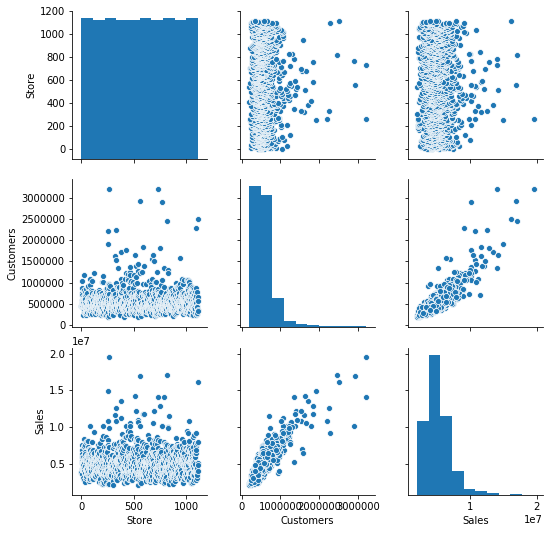

In [47]:
sns.pairplot(base_df)

### i.	Dimensionality Reduction

#### i.	PCA

#### ii.	LDA

# Model Building

In [102]:
#Identifying the right number of clusters

In [58]:
# Using the elbow method to find the optimal number of clusters
import matplotlib.pyplot as plt

def kelbow(df,k):
    from sklearn.cluster import KMeans
    x = []
    for i in range(1,k):
        kmeans = KMeans(n_clusters = i)
        kmeans.fit(df)
        x.append(kmeans.inertia_)

    plt.plot(range(1,k), x)
    plt.title('The elbow method')
    plt.xlabel('The number of clusters')
    plt.ylabel('WCSS')
    plt.show()
    return x

In [60]:
#Clustering

In [62]:
base_df.head()

,Store,Customers,Sales
0,1,440523.0,3716854
1,2,457855.0,3883858
2,3,584310.0,5408261
3,4,1036254.0,7556507
4,5,418588.0,3642818


In [63]:
from sklearn.cluster import KMeans
km=KMeans(n_clusters=5)
km.fit(base_df[['Sales','Customers']])
len(km.predict(base_df[['Sales','Customers']]))

1115

In [64]:
km.predict(base_df[['Sales','Customers']])

array([2, 2, 1, ..., 1, 4, 1])

In [65]:
base_df['cluster']=km.predict(base_df[['Sales','Customers']])

In [67]:
base_df.head(5)

,Store,Customers,Sales,cluster
0,1,440523.0,3716854,2
1,2,457855.0,3883858,2
2,3,584310.0,5408261,1
3,4,1036254.0,7556507,3
4,5,418588.0,3642818,2


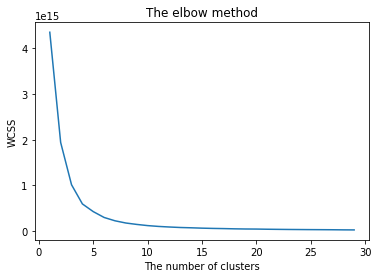

[4345049696626034.0,
 1938582891640305.5,
 1016072089101022.2,
 597029831445722.4,
 429164657380510.1,
 301458376521732.6,
 228921412868847.3,
 180547523119930.72,
 149862823863594.44,
 124244064990367.97,
 106129481844273.17,
 93475591488777.0,
 82766605251334.48,
 76317436275891.06,
 68338364459534.52,
 62726128136799.266,
 58788620357286.14,
 53610707648890.28,
 50001908278314.94,
 48438226241172.25,
 44751820730764.11,
 42098862619438.94,
 39702815825940.17,
 38077694268899.984,
 36399178174317.31,
 35088439043595.4,
 33624023826331.906,
 31261922687165.086,
 29915222654518.336]

In [68]:
kelbow(base_df,30)

In [69]:
#Visualizing teh clusters

In [71]:
base_df['cluster'].value_counts()

1    442
2    403
3    223
0     37
4     10
Name: cluster, dtype: int64

In [75]:
base_df_c1=base_df[base_df['cluster']==1]

In [78]:
base_df_c1['Sales'].mean()

5227696.484162896

In [77]:
base_df_c1.shape

(442, 4)

In [87]:
base_df_c1[base_df_c1['Sales']<base_df_c1['Sales'].mean()]['Store'].values.shape

(218,)

In [88]:
potential_stores=base_df_c1[base_df_c1['Sales']<base_df_c1['Sales'].mean()]

In [89]:
potential_stores.head()

,Store,Customers,Sales,cluster
8,9,451677.0,5112061,1
16,17,619090.0,4954488,1
17,18,557785.0,5130137,1
18,19,486618.0,5036169,1
19,20,525258.0,4801543,1


In [98]:
abs(potential_stores['Sales']-base_df_c1['Sales'].mean()).sum()

91046279.54751131

In [101]:
(abs(potential_stores['Sales']-base_df_c1['Sales'].mean()).sum())/potential_stores.shape[0]

417643.48416289594

### a.	Supervised

#### i.	Regression

#### ii.	Classification

### b.	Unsupervised

#### i.	Hierarchical  clustering

#### ii.	Centre based clustering 

### c.	Time Series

#### i.	ARIMA

#### ii.	ARIMAX